In [1]:
import numpy as np
import numba

# Phase boundary derivation

In [11]:
np.linspace(0.25, 2.25, 25)

array([0.25      , 0.33333333, 0.41666667, 0.5       , 0.58333333,
       0.66666667, 0.75      , 0.83333333, 0.91666667, 1.        ,
       1.08333333, 1.16666667, 1.25      , 1.33333333, 1.41666667,
       1.5       , 1.58333333, 1.66666667, 1.75      , 1.83333333,
       1.91666667, 2.        , 2.08333333, 2.16666667, 2.25      ])

<hr>

__What is the critical density as a function of g? Can we derive this or do we need to simulate it?__

Based on our model, there should be a critical cell density above which there is no longer a stable "ON" state for the system. To find this, we will first derive an expression for the steady-state ligand expression, expressed as a vector $s_{ss}$.

\begin{align}
0 &= \frac{\mathrm{d} s}{\mathrm{d} t} = \lambda + \alpha \frac{s_t^p}{\left(g^2 k \right)^p + \left(\delta s_{ss} \right)^p + s_t^p} - g s_{ss} \\[1em]
&= \lambda + \alpha \frac{\big(\beta(\rho) A s_{ss}\big)^p}{\left(g^2 k \right)^p + \left(\delta s_{ss} \right)^p + \big(\beta(\rho) A s_{ss}\big)^p} - g s_{ss} \\[1em]
\end{align} 

Solving this expression amounts to solving a system of $n$ polynomial equations. Instead of this, we can simply simulate the system for a sufficient time to equilibrate to steady-state. 

This expression also depends on the spatial patterning of transceiver cells and sender cells, encoded in the adjacency matrix $A$. To interrogate the "ON" state, we will examine the case when sender cells are present, providing constant stimulation to the transceiver cells in the system. 

Above a critical density $\rho_\text{crit}$, the transceivers should cease to activate in aggregate. We interrogate this by comparing the mean fluorescence at steady-state to a fluorescence threshold. Since the promoter threshold $k$ is a natural threshold, we will consider the system is activated when $s_{ss,\text{ mean}} > k$.

__Produce a relation for $\rho_\text{crit}(g)$ at static densities__

__(If approximation, insert plot like `constant_dens_plot2`)__

In [16]:
@numba.njit
def rho_crit_approx(g, a=3.1, b=4.1):
    return a - b * np.log10(g)

__Given $\rho_\text{crit}$, calculate $t_\text{crit}$__

Given the critical density $\rho_\text{crit}$, where $\rho_0 < \rho_\text{crit} < \rho_\text{max}$, we can then write the logistic equation in terms of $\rho_\text{crit}$ and the time it will take to reach critical behavior $t_\text{crit}$.

\begin{align}
\rho_\text{crit} &= \frac{\rho_\text{max}}{1 + \frac{\rho_\text{max} - \rho_0}{\rho_0} e^{-g t_\text{crit}}} \\[1em]
\end{align}

Then we can solve for $t_\text{crit}$.

\begin{align}
1 + \frac{\rho_\text{max} - \rho_0}{\rho_0} e^{-g t_\text{crit}} &= \frac{\rho_\text{max}}{\rho_\text{crit}} \\[1em]
e^{-g t_\text{crit}} &= \frac{\rho_\text{max} - \rho_\text{crit}}{\rho_\text{crit}} \cdot \frac{\rho_0}{\rho_\text{max} - \rho_0} \\[1em]
t_\text{crit} &= -\frac{1}{g} \left(\ln\frac{\rho_\text{max} - \rho_\text{crit}}{\rho_\text{crit}} - \ln\frac{\rho_\text{max} - \rho_0}{\rho_0} \right) \\[1em]
\end{align}

In [17]:
@numba.njit
def t_crit_approx(g, rho_0, rho_max, *rho_crit_args):
    rho_crit = rho_crit_approx(g, *rho_crit_args)
    return -1/g * np.log((rho_max - rho_crit) / rho_crit * rho_0 / (rho_max - rho_0) )

We can also ask, at what time does phase behavior change? We can visualize this by selecting values of $t_\text{crit}$ and plotting the parameters that satisfy this. This will give us manifolds in phase space (level sets) that describe when critical behavior will occur.

\begin{align}
- g t_\text{crit} &= \ln\frac{\rho_\text{max} - \rho_\text{crit}}{\rho_\text{crit}} - \ln\frac{\rho_\text{max} - \rho_0}{\rho_0} \\[1em]
\ln\frac{\rho_\text{max} - \rho_0}{\rho_0} &= \ln\frac{\rho_\text{max} - \rho_\text{crit}}{\rho_\text{crit}} + g t_\text{crit}\\[1em]
\frac{\rho_\text{max}}{\rho_0} - 1 &= \frac{\rho_\text{max} - \rho_\text{crit}}{\rho_\text{crit}} e^{g t_\text{crit}} \\[1em]
\rho_0 &= \frac{\rho_\text{max}\rho_\text{crit}}{\rho_\text{crit} + \left(\rho_\text{max} - \rho_\text{crit}\right) e^{g t_\text{crit}}} \\[1em]
\end{align}

In [18]:
@numba.njit
def t_crit_approx_levelset(t_crit, g, rho_max, *rho_crit_args):
    rho_crit = rho_crit_approx(g, *rho_crit_args)
    return rho_max * rho_crit / (rho_crit + (rho_max - rho_crit) * np.exp(g * t_crit))

<hr>

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

import colorcet as cc

In [16]:
@numba.njit
def rho_crit_approx(g, a=3.1, b=4.1):
    return a - b * np.log10(g)

In [17]:
@numba.njit
def t_crit_approx(g, rho_0, rho_max, *rho_crit_args):
    rho_crit = rho_crit_approx(g, *rho_crit_args)
    return -1/g * np.log((rho_max - rho_crit) / rho_crit * rho_0 / (rho_max - rho_0) )

In [18]:
@numba.njit
def t_crit_approx_levelset(t_crit, g, rho_max, *rho_crit_args):
    rho_crit = rho_crit_approx(g, *rho_crit_args)
    return rho_max * rho_crit / (rho_crit + (rho_max - rho_crit) * np.exp(g * t_crit))

## Plotting the level sets

In [83]:
rho_crit_approx(10**0.75)

0.025000000000000355

In [111]:
t_crit = 20
rho_max_ls = np.linspace(1, 8, 50)
log10g_ls = np.linspace(-1, 0.75, 50)

In [112]:
X, Y = np.meshgrid(log10g_ls, rho_max_ls)
rho_crit_ls = rho_crit_approx(10**X)
Z = t_crit_approx_levelset(t_crit, 10**X, Y)

In [113]:
tol = 1e-5
valid_samples = np.logical_and(Y - rho_crit_ls >= -tol, rho_crit_ls - Z >= -tol)

xx, yy, zz = X[valid_samples], Y[valid_samples], Z[valid_samples]

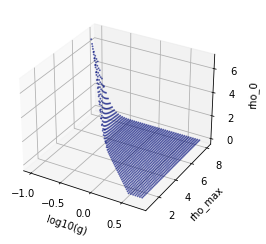

In [114]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('log10(g)')
ax.set_ylabel('rho_max')
ax.set_zlabel('rho_0')
ax.scatter(xx, yy, zz, c=cc.bmy[0], s=1, alpha=0.5);

<hr>